## Iris flower supervised learning with TF 2.0 beta

( modified from [Custom training: walktrough](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/eager/custom_training_walkthrough.ipynb) -  https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough )

In [1]:
# Copyright 2018 The TensorFlow Authors
#
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

This guide uses machine learning to *categorize* Iris flowers by species. It uses TensorFlow's [eager execution](https://www.tensorflow.org/guide/eager) to:
1. Build a model,
2. Train this model on example data, and
3. Use the model to make predictions about unknown data.

## TensorFlow programming

This guide uses these high-level TensorFlow concepts:

* Enable an [eager execution](https://www.tensorflow.org/guide/eager) development environment,
* Import data with the [Datasets API](https://www.tensorflow.org/guide/datasets),
* Build models and layers with TensorFlow's [Keras API](https://keras.io/getting-started/sequential-model-guide/).

This tutorial is structured like many TensorFlow programs:

1. Import and parse the data sets.
2. Select the type of model.
3. Train the model.
4. Evaluate the model's effectiveness.
5. Use the trained model to make predictions.

## Setup program

### Configure imports and eager execution

Import the required Python modules—including TensorFlow—and enable eager execution for this program. Eager execution makes TensorFlow evaluate operations immediately, returning concrete values instead of creating a [computational graph](https://www.tensorflow.org/guide/graphs) that is executed later. If you are used to a REPL or the `python` interactive console, this feels familiar. Eager execution is available in [Tensorlow >=1.8](https://www.tensorflow.org/install/).


In [2]:
import os
import matplotlib.pyplot as plt

import tensorflow as tf

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.0.0-beta1
Eager execution: True


## The Iris classification problem

Imagine you are a botanist seeking an automated way to categorize each Iris flower you find. Machine learning provides many algorithms to classify flowers statistically. For instance, a sophisticated machine learning program could classify flowers based on photographs. Our ambitions are more modest—we're going to classify Iris flowers based on the length and width measurements of their [sepals](https://en.wikipedia.org/wiki/Sepal) and [petals](https://en.wikipedia.org/wiki/Petal).

The Iris genus entails about 300 species, but our program will only classify the following three:

* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="./assets/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
</table>

**Figure 1** <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (from [Wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)).<br/>&nbsp;

## Import and parse the training dataset

Download the dataset file and convert it into a structure that can be used by this Python program.

### Download the dataset

Download the training dataset file using the [tf.keras.utils.get_file](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) function. This returns the file path of the downloaded file.

In [3]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"

train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url),
                                           origin=train_dataset_url)

print("Local copy of the dataset file: {}".format(train_dataset_fp))

Local copy of the dataset file: /Users/arvid/.keras/datasets/iris_training.csv


### Inspect the data

This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Use the `head -n5` command to take a peak at the first five entries:

In [4]:
# !head -n5 {train_dataset_fp}
get_ipython().system('head -n5 {train_dataset_fp}')

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


From this view of the dataset, notice the following:

1. The first line is a header containing information about the dataset:
  * There are 120 total examples. Each example has four features and one of three possible label names.
2. Subsequent rows are data records, one *[example](https://developers.google.com/machine-learning/glossary/#example)* per line, where:
  * The first four fields are *[features](https://developers.google.com/machine-learning/glossary/#feature)*: these are characteristics of an example. Here, the fields hold float numbers representing flower measurements.
  * The last column is the *[label](https://developers.google.com/machine-learning/glossary/#label)*: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.

Let's write that out in code:

In [5]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']

feature_names = column_names[:-1]
label_name = column_names[-1]

print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

For more information about features and labels, see the [ML Terminology section of the Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology).

In [6]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

### Create a `tf.data.Dataset`

TensorFlow's [Dataset API](https://www.tensorflow.org/guide/datasets) handles many common cases for loading data into a model. This is a high-level API for reading data and transforming it into a form used for training. See the [Datasets Quick Start guide](https://www.tensorflow.org/get_started/datasets_quickstart) for more information.


Since the dataset is a CSV-formatted text file, use the [make_csv_dataset](https://www.tensorflow.org/api_docs/python/tf/contrib/data/make_csv_dataset) function to parse the data into a suitable format. Since this function generates data for training models, the default behavior is to shuffle the data (`shuffle=True, shuffle_buffer_size=10000`), and repeat the dataset forever (`num_epochs=None`). We also set the [batch_size](https://developers.google.com/machine-learning/glossary/#batch_size) parameter.

In [7]:
batch_size = 32

#train_dataset = tf.contrib.data.make_csv_dataset(
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

W0730 23:09:36.948755 4466288064 deprecation.py:323] From /Users/arvid/anaconda3/envs/tf2-cpu/lib/python3.7/site-packages/tensorflow/python/data/experimental/ops/readers.py:498: parallel_interleave (from tensorflow.python.data.experimental.ops.interleave_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_determinstic`.


The `make_csv_dataset` function returns a `tf.data.Dataset` of `(features, label)` pairs, where `features` is a dictionary: `{'feature_name': value}`

With eager execution enabled, these `Dataset` objects are iterable. Let's look at a batch of features:

In [8]:
features, labels = next(iter(train_dataset))

features

OrderedDict([('sepal_length',
              <tf.Tensor: id=65, shape=(32,), dtype=float32, numpy=
              array([6.1, 6.9, 7.2, 4.9, 6.4, 5. , 6.4, 5.4, 7.7, 5.7, 4.7, 4.9, 6.4,
                     5.6, 6.5, 7.9, 5. , 4.9, 5.8, 6.5, 4.6, 6.6, 6.7, 5. , 4.9, 5.9,
                     5.1, 4.5, 6.2, 6.8, 5.5, 5.4], dtype=float32)>),
             ('sepal_width',
              <tf.Tensor: id=66, shape=(32,), dtype=float32, numpy=
              array([2.8, 3.2, 3. , 3.1, 3.2, 3. , 2.8, 3.9, 2.8, 3. , 3.2, 2.5, 3.1,
                     2.7, 3.2, 3.8, 3.4, 3.1, 2.6, 2.8, 3.6, 2.9, 3. , 3.4, 3. , 3. ,
                     3.8, 2.3, 3.4, 3. , 3.5, 3. ], dtype=float32)>),
             ('petal_length',
              <tf.Tensor: id=63, shape=(32,), dtype=float32, numpy=
              array([4.7, 5.7, 5.8, 1.5, 4.5, 1.6, 5.6, 1.7, 6.7, 4.2, 1.6, 4.5, 5.5,
                     4.2, 5.1, 6.4, 1.5, 1.5, 4. , 4.6, 1. , 4.6, 5. , 1.6, 1.4, 5.1,
                     1.5, 1.3, 5.4, 5.5, 1.3, 4.5],

Notice that like-features are grouped together, or *batched*. Each example row's fields are appended to the corresponding feature array. Change the `batch_size` to set the number of examples stored in these feature arrays.

You can start to see some clusters by plotting a few features from the batch:

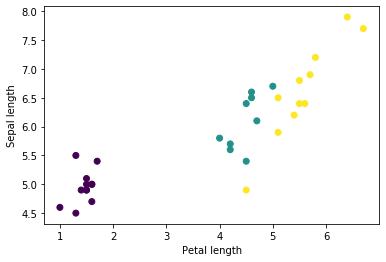

In [9]:
plt.scatter(features['petal_length'].numpy(),
            features['sepal_length'].numpy(),
            c=labels.numpy(),
            cmap='viridis')

plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

To simplify the model building step, create a function to repackage the features dictionary into a single array with shape: `(batch_size, num_features)`.

This function uses the [tf.stack](https://www.tensorflow.org/api_docs/python/tf/stack) method which takes values from a list of tensors and creates a combined tensor at the specified dimension.

In [10]:
def pack_features_vector(features, labels):
  """Pack the features into a single array."""
  features = tf.stack(list(features.values()), axis=1)
  return features, labels

Then use the [tf.data.Dataset.map](https://www.tensorflow.org/api_docs/python/tf/data/dataset/map) method to pack the `features` of each `(features,label)` pair into the training dataset:

In [11]:
train_dataset = train_dataset.map(pack_features_vector)

The features element of the `Dataset` are now arrays with shape `(batch_size, num_features)`. Let's look at the first few examples:

In [12]:
features, labels = next(iter(train_dataset))

print(features[:5])

tf.Tensor(
[[6.1 2.8 4.7 1.2]
 [6.9 3.2 5.7 2.3]
 [7.2 3.  5.8 1.6]
 [4.9 3.1 1.5 0.1]
 [6.4 3.2 4.5 1.5]], shape=(5, 4), dtype=float32)


## Select the type of model

### Why model?

A *[model](https://developers.google.com/machine-learning/crash-course/glossary#model)* is a relationship between features and the label.  For the Iris classification problem, the model defines the relationship between the sepal and petal measurements and the predicted Iris species. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

Could you determine the relationship between the four features and the Iris species *without* using machine learning?  That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model?  Perhaps—if you analyzed the dataset long enough to determine the relationships between petal and sepal measurements to a particular species. And this becomes difficult—maybe impossible—on more complicated datasets. A good machine learning approach *determines the model for you*. If you feed enough representative examples into the right machine learning model type, the program will figure out the relationships for you.

### Select the model

We need to select the kind of model to train. There are many types of models and picking a good one takes experience. This tutorial uses a neural network to solve the Iris classification problem. *[Neural networks](https://developers.google.com/machine-learning/glossary/#neural_network)* can find complex relationships between features and the label. It is a highly-structured graph, organized into one or more *[hidden layers](https://developers.google.com/machine-learning/glossary/#hidden_layer)*. Each hidden layer consists of one or more *[neurons](https://developers.google.com/machine-learning/glossary/#neuron)*. There are several categories of neural networks and this program uses a dense, or *[fully-connected neural network](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)*: the neurons in one layer receive input connections from *every* neuron in the previous layer. For example, Figure 2 illustrates a dense neural network consisting of an input layer, two hidden layers, and an output layer:

<table>
  <tr><td>
    <img src="./assets/full_network.png"
         alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>

When the model from Figure 2 is trained and fed an unlabeled example, it yields three predictions: the likelihood that this flower is the given Iris species. This prediction is called *[inference](https://developers.google.com/machine-learning/crash-course/glossary#inference)*. For this example, the sum of the output predictions is 1.0. In Figure 2, this prediction breaks down as: `0.02` for *Iris setosa*, `0.95` for *Iris versicolor*, and `0.03` for *Iris virginica*. This means that the model predicts—with 95% probability—that an unlabeled example flower is an *Iris versicolor*.

### Create a model using Keras

The TensorFlow [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras) API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers with 10 nodes each, and an output layer with 3 nodes representing our label predictions. The first layer's `input_shape` parameter corresponds to the number of features from the dataset, and is required.

In [13]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

The *[activation function](https://developers.google.com/machine-learning/crash-course/glossary#activation_function)* determines the output shape of each node in the layer. These non-linearities are important—without them the model would be equivalent to a single layer. There are many [available activations](https://www.tensorflow.org/api_docs/python/tf/keras/activations), but [ReLU](https://developers.google.com/machine-learning/crash-course/glossary#ReLU) is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

We can also plot the model as a graph:

```python
# tf.keras.utils.plot_model needs
!pip install pydot
!pip install graphviz
```

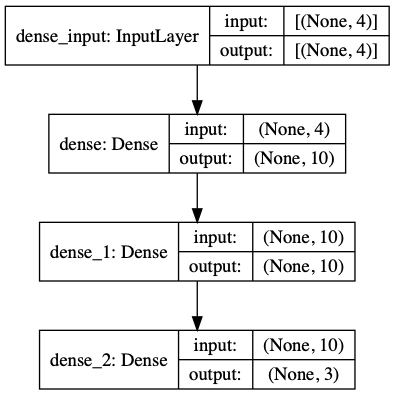

In [14]:
tf.keras.utils.plot_model(model, '/tmp/my_keras_model_iris_classification.png', show_shapes=True)

### Using the model

Let's have a quick look at what this model does to a batch of features:

In [15]:
predictions = model(features)
predictions[:5]

<tf.Tensor: id=206, shape=(5, 3), dtype=float32, numpy=
array([[2.2646756 , 1.4492695 , 1.5932099 ],
       [3.009518  , 1.607137  , 2.1239314 ],
       [2.9209962 , 1.8151073 , 2.2375455 ],
       [1.8143198 , 0.47320533, 0.618647  ],
       [2.2039886 , 1.3521533 , 1.2376357 ]], dtype=float32)>

Here, each example returns a [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits) for each class.

To convert these logits to a probability for each class, use the [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) function:

In [16]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: id=212, shape=(5, 3), dtype=float32, numpy=
array([[0.511923  , 0.22650526, 0.2615717 ],
       [0.6029607 , 0.14833468, 0.24870452],
       [0.54472506, 0.18025857, 0.27501634],
       [0.63936394, 0.16722819, 0.1934078 ],
       [0.553373  , 0.2360862 , 0.2105408 ]], dtype=float32)>

Taking the `tf.argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions.

In [17]:
print("Prediction: {}".format(tf.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [1 2 2 0 1 0 2 0 2 1 0 2 2 1 2 2 0 0 1 1 0 1 1 0 0 2 0 0 2 2 0 1]


## Train the model

*[Training](https://developers.google.com/machine-learning/crash-course/glossary#training)* is the stage of machine learning when the model is gradually optimized, or the model *learns* the dataset. The goal is to learn enough about the structure of the training dataset to make predictions about unseen data. If you learn *too much* about the training dataset, then the predictions only work for the data it has seen and will not be generalizable. This problem is called *[overfitting](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)*—it's like memorizing the answers instead of understanding how to solve a problem.

The Iris classification problem is an example of *[supervised machine learning](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)*: the model is trained from examples that contain labels. In *[unsupervised machine learning](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)*, the examples don't contain labels. Instead, the model typically finds patterns among the features.

### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the [tf.keras.losses.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/losses/sparse_softmax_cross_entropy) function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

tf.losses.sparse_softmax_cross_entropy

In [18]:
def loss(model, x, y):
  y_ = model(x)
  # return tf.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)
  return tf.compat.v1.losses.sparse_softmax_cross_entropy(labels=y, logits=y_)

l = loss(model, features, labels)
print("Loss test: {}".format(l))

Loss test: 1.0361303091049194


Use the [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) context to calculate the *[gradients](https://developers.google.com/machine-learning/crash-course/glossary#gradient)* used to optimize our model. For more examples of this, see the [eager execution guide](https://www.tensorflow.org/guide/eager).

In [19]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Create an optimizer

An *[optimizer](https://developers.google.com/machine-learning/crash-course/glossary#optimizer)* applies the computed gradients to the model's variables to minimize the `loss` function. You can think of the loss function as a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="./assets/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

TensorFlow has many [optimization algorithms](https://www.tensorflow.org/api_guides/python/train) available for training. This model uses the [tf.train.GradientDescentOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer) that implements the *[stochastic gradient descent](https://developers.google.com/machine-learning/crash-course/glossary#gradient_descent)* (SGD) algorithm. The `learning_rate` sets the step size to take for each iteration down the hill. This is a *hyperparameter* that you'll commonly adjust to achieve better results.

Let's setup the optimizer and the `global_step` counter:

In [20]:
# optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
optimizer = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.01)

global_step = tf.Variable(0)

We'll use this to calculate a single optimization step:

In [21]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(global_step.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables), global_step)

print("Step: {},         Loss: {}".format(global_step.numpy(),
                                          loss(model, features, labels).numpy()))

Step: 0, Initial Loss: 1.0361303091049194
Step: 1,         Loss: 0.9835832118988037


### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use an `optimizer` to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. `num_epochs` is a *[hyperparameter](https://developers.google.com/machine-learning/glossary/#hyperparameter)* that you can tune. Choosing the right number usually requires both experience and experimentation.

In [22]:
## Note: Rerunning this cell uses the same model variables

#from tensorflow import contrib
#tfe = contrib.eager

# keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  # epoch_loss_avg = tfe.metrics.Mean()
  # epoch_accuracy = tfe.metrics.Accuracy()
  epoch_loss_avg = tf.metrics.Mean()
  epoch_accuracy = tf.metrics.Accuracy()

  # Training loop - using batches of 32
  for x, y in train_dataset:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),
                              global_step)

    # Track progress
    epoch_loss_avg(loss_value)  # add current batch loss
    # compare predicted label to actual label
    epoch_accuracy(tf.argmax(model(x), axis=1, output_type=tf.int32), y)

  # end epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))

Epoch 000: Loss: 0.947, Accuracy: 41.667%
Epoch 050: Loss: 0.282, Accuracy: 97.500%
Epoch 100: Loss: 0.186, Accuracy: 96.667%
Epoch 150: Loss: 0.145, Accuracy: 97.500%
Epoch 200: Loss: 0.124, Accuracy: 97.500%


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often *more* helpful to see this progress. [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard) is a nice visualization tool that is packaged with TensorFlow, but we can create basic charts using the `matplotlib` module.

Interpreting these charts takes some experience, but you really want to see the *loss* go down and the *accuracy* go up.

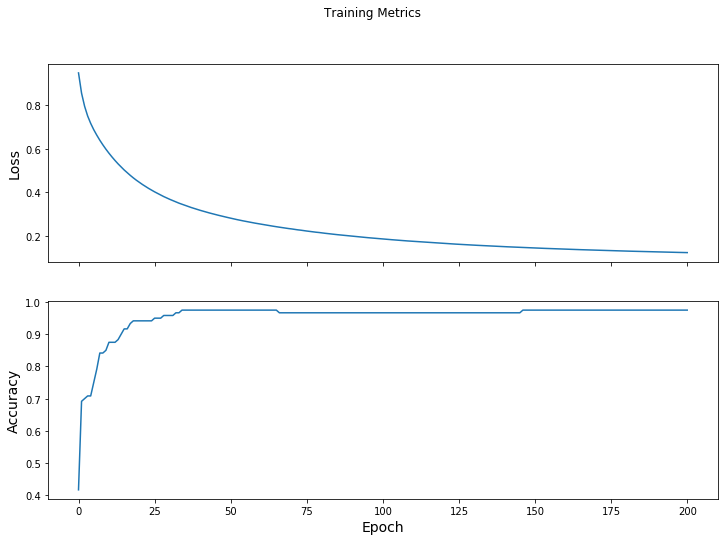

In [23]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

## Evaluate the model's effectiveness

Now that the model is trained, we can get some statistics on its performance.

*Evaluating* means determining how effectively the model makes predictions. To determine the model's effectiveness at Iris classification, pass some sepal and petal measurements to the model and ask the model to predict what Iris species they represent. Then compare the model's prediction against the actual label.  For example, a model that picked the correct species on half the input examples has an *[accuracy](https://developers.google.com/machine-learning/glossary/#accuracy)* of `0.5`. Figure 4 shows a slightly more effective model, getting 4 out of 5 predictions correct at 80% accuracy:

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">Example features</th>
    <th colspan="1">Label</th>
    <th colspan="1" >Model prediction</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>Figure 4.</b> An Iris classifier that is 80% accurate.<br/>&nbsp;
  </td></tr>
</table>

### Setup the test dataset

Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate *[test set](https://developers.google.com/machine-learning/crash-course/glossary#test_set)* rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The setup for the test `Dataset` is similar to the setup for training `Dataset`. Download the CSV text file and parse that values, then give it a little shuffle:

In [24]:
test_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv"

test_fp = tf.keras.utils.get_file(fname=os.path.basename(test_url),
                                  origin=test_url)
print("Local copy of the test dataset file: {}".format(test_fp))

Local copy of the test dataset file: /Users/arvid/.keras/datasets/iris_test.csv


In [25]:
#test_dataset = tf.contrib.data.make_csv_dataset(
test_dataset = tf.data.experimental.make_csv_dataset(
    test_fp,
    batch_size,
    column_names=column_names,
    label_name='species',
    num_epochs=1,
    shuffle=False)

test_dataset = test_dataset.map(pack_features_vector)

### Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single [epoch](https://developers.google.com/machine-learning/glossary/#epoch) of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set.

In [26]:
#test_accuracy = tfe.metrics.Accuracy()
test_accuracy = tf.metrics.Accuracy()

for (x, y) in test_dataset:
  logits = model(x)
  prediction = tf.argmax(logits, axis=1, output_type=tf.int32)
  test_accuracy(prediction, y)

print("Test set accuracy: {:.3%}".format(test_accuracy.result()))

Test set accuracy: 100.000%


We can see on the last batch, for example, the model is usually correct:

In [27]:
tf.stack([y,prediction],axis=1)

<tf.Tensor: id=104456, shape=(30, 2), dtype=int32, numpy=
array([[1, 1],
       [2, 2],
       [0, 0],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [2, 2],
       [1, 1],
       [2, 2],
       [2, 2],
       [0, 0],
       [2, 2],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [0, 0],
       [0, 0],
       [2, 2],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [0, 0],
       [1, 1],
       [2, 2],
       [1, 1]], dtype=int32)>

## Use the trained model to make predictions

We've trained a model and "proven" that it's good—but not perfect—at classifying Iris species. Now let's use the trained model to make some predictions on [unlabeled examples](https://developers.google.com/machine-learning/glossary/#unlabeled_example); that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [28]:
predict_dataset = tf.convert_to_tensor([
    [5.1, 3.3, 1.7, 0.5,],
    [5.9, 3.0, 4.2, 1.5,],
    [6.9, 3.1, 5.4, 2.1]
])

predictions = model(predict_dataset)

for i, logits in enumerate(predictions):
  class_idx = tf.argmax(logits).numpy()
  p = tf.nn.softmax(logits)[class_idx]
  name = class_names[class_idx]
  print("Example {} prediction: {} ({:4.1f}%)".format(i, name, 100*p))

Example 0 prediction: Iris setosa (98.3%)
Example 1 prediction: Iris versicolor (95.3%)
Example 2 prediction: Iris virginica (69.5%)
